torch.Size([3, 300, 300])


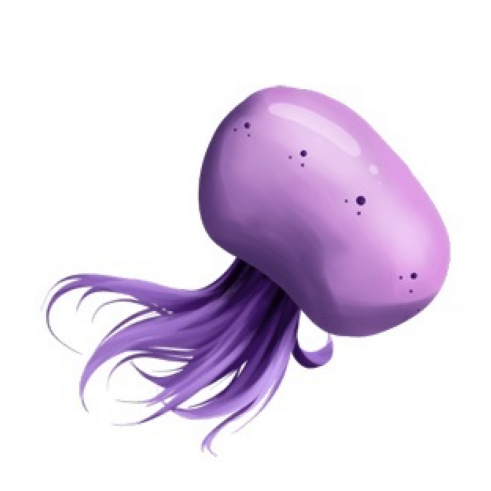

In [1]:
from glio.importsall import *
from scipy.signal import convolve as scipy_convolve
from scipy.signal import correlate as scipy_correlate

from torchzero.nn.functional.convolve import convolve, correlate, _get_conv_patches
image:torch.Tensor = znorm(imreadtensor(r"C:\Users\nkshv\Pictures\AA_AerofleetArt.jpg").float())
print(image.shape)
kernel = torch.tensor([[[1, 0, -1], [2, 0, -2], [1, 0, -1]]]).float()
qimshow(image)

In [2]:
input = torch.randn(3, 32, 32)
kernel = torch.randn(1, 5, 5)
patched = input.unfold(1, 5, 1).unfold(2, 5, 1) # patched.shape = 3, 28, 28, 5, 5
convolved = (patched * kernel).sum((-1, -2))
print(convolved.shape) # 3, 28, 28

torch.Size([3, 28, 28])


In [3]:
batch_size = 8
in_channels = 3
out_channels = 16
H = 32
W = 32
K1 = K2 = 5
input = torch.randn(batch_size, in_channels, 32, 32)
input_processed = input.unsqueeze(-1).expand(*input.size(), out_channels).movedim(1, -1)
# input_processed.shape = (batch_size, H, W, out_channels, in_channels)
kernel = torch.randn(out_channels, in_channels, K1, K2)
# kernel.shape = (out_channels, in_channels, 5, 5)
patched = input_processed.unfold(-4, K1, 1).unfold(-4, K2, 1)
# patched.shape = (batch_size, 28, 28, out_channels, in_channels, 5, 5)
convolved = (patched * kernel).sum((-1, -2, -3)).movedim(-1, 1)
# convolved.shape = (batch_size, out_channels, 28, 28)

# i've tested and it matches conv2d

In [4]:
batch_size = 16
in_channels = 32
out_channels = 32
H = 28
W = 28
K1 = K2 = 5
input = torch.randn(batch_size, in_channels, 32, 32, device = torch.device('cuda'))
kernel = torch.randn(out_channels, in_channels, K1, K2, device = torch.device('cuda'))
def conv2d_layer(input:torch.Tensor, kernel:torch.Tensor):
    ksize = kernel.shape[-2:]
    input = input.unsqueeze(-1).expand(*input.size(), out_channels).movedim(1, -1)
    # input.shape = (batch_size, H, W, out_channels, in_channels)
    patched = input.unfold(-4, ksize[0], 1).unfold(-4, ksize[1], 1)
    # patched.shape = (batch_size, 28, 28, out_channels, in_channels, 5, 5)
    return (patched * kernel).sum((-1, -2, -3)).movedim(-1, 1)
    # return.shape = (batch_size, out_channels, 28, 28)


In [5]:
a = torch.tensor([3,1])


In [6]:
def conv2d_layer2(input: torch.Tensor, kernel: torch.Tensor):
    ksize = kernel.shape[-2:]
    return (
        (
            input.unsqueeze(-1)
            .expand(*input.size(), out_channels)
            .movedim(1, -1)
            .unfold(-4, ksize[0], 1)
            .unfold(-4, ksize[1], 1)
            * kernel
        )
        .sum((-1, -2, -3))
        .movedim(-1, 1)
    )


In [7]:
def conv2d_layer3(input: torch.Tensor, kernel: torch.Tensor):
    ksize = kernel.shape[-2:]
    out_channels = kernel.shape[0]
    # input.shape = (batch_size, in_channels, H, W)
    return (
        (
            input.unfold(-2, ksize[0], 1)
            .unfold(-2, ksize[1], 1)
            .expand(out_channels, *([-1] * 6))
            * kernel[:, None, :, None, None]
        )
        .sum((2, 5, 6))
        .swapaxes(0, 1)
    )

In [61]:
clean_mem()

In [10]:
with perf_counter_context():
    for _ in range(10):
        torch.nn.functional.conv2d(input, kernel)

Context took 0.002827199990861118 perf_counter seconds


In [60]:
with perf_counter_context():
    for _ in range(10):
        conv2d_layer3(input, kernel)

Context took 0.003133099991828203 perf_counter seconds


# Normal convolution

torch.Size([3, 298, 300])


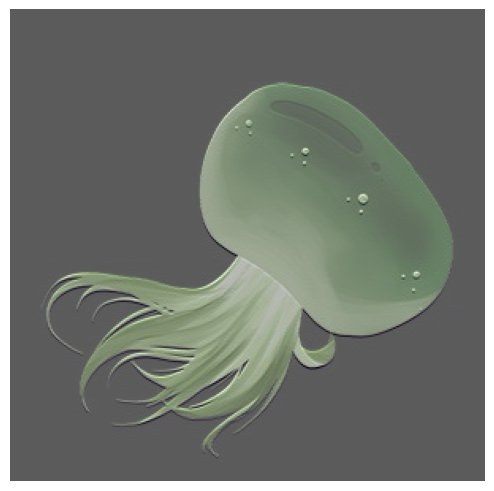

In [2]:
K = torch.randn(1, 3,1)
out = convolve(image, K)
print(out.shape)
qimshow(out)

(3, 302, 300)


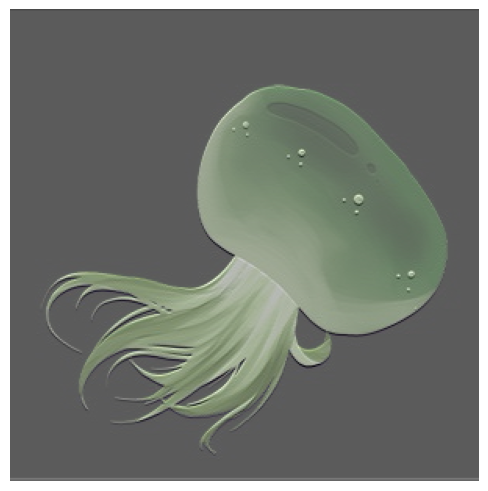

In [3]:
out = scipy_convolve(image, K)
print(out.shape)
qimshow(out)

# Full convolution

torch.Size([3, 302, 302])


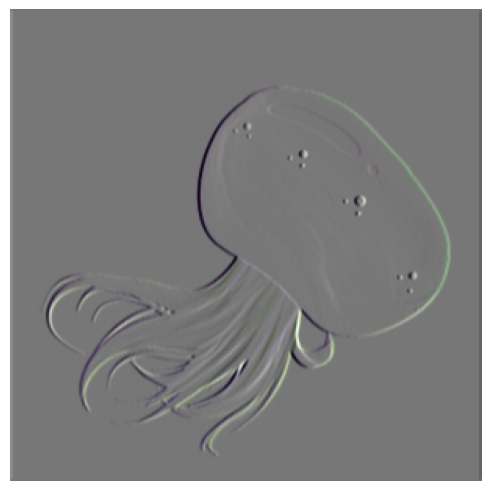

In [4]:
out = convolve(image, kernel, mode='full')
print(out.shape)
qimshow(out)

(3, 302, 302)


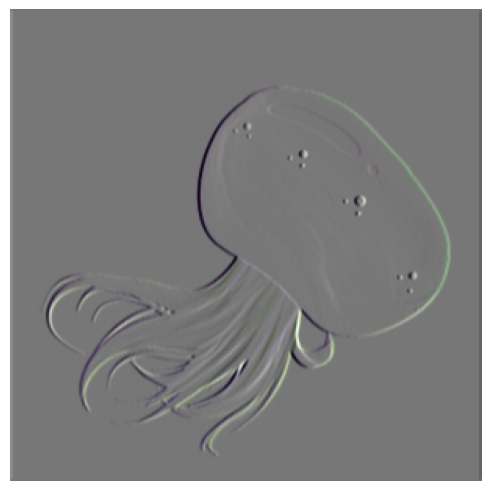

In [5]:
out = scipy_convolve(image, kernel, mode='full')
print(out.shape)
qimshow(out)

# same mode convolution

[0, 2, 2]
torch.Size([3, 300, 300])


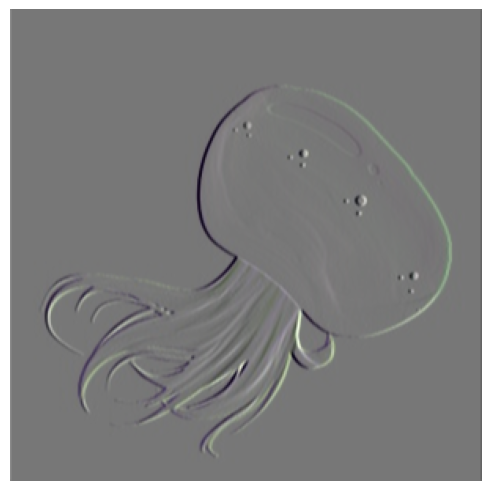

In [6]:
out = convolve(image, kernel, mode='same')
print(out.shape)
qimshow(out)

torch.Size([3, 298, 298])


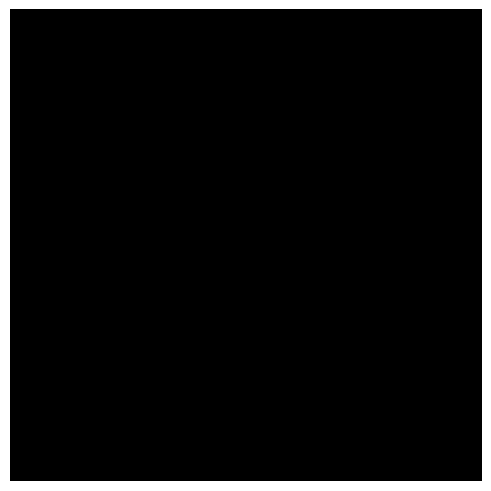

In [7]:
from torchzero.nn.functional.pad import pad
from torchzero.nn.functional.crop import crop_to_shape

def correlate_prod(
    in1: torch.Tensor,
    in2: torch.Tensor,
    stride: int | Sequence[int] = 1,
    mode: Literal['full', 'valid', 'same'] = "valid",
    padding: int | Sequence[int] = 0,
    padding_mode="constant",
    value=None,
) -> torch.Tensor:
    patches, nreducedims = _get_conv_patches(
        in1,
        in2,
        stride=stride,
        mode=mode,
        padding=padding,
        padding_mode=padding_mode,
        value=value,
    )

    if mode in ('valid', 'full'): return (patches * in2).flatten(-nreducedims, -1).prod(-1)
    return crop_to_shape((patches * in2).flatten(-nreducedims, -1).prod(-1), shape = in1.size(), where='center')

out = correlate_prod(image, kernel)
print(out.shape)
qimshow(out)

torch.Size([3, 291, 291])


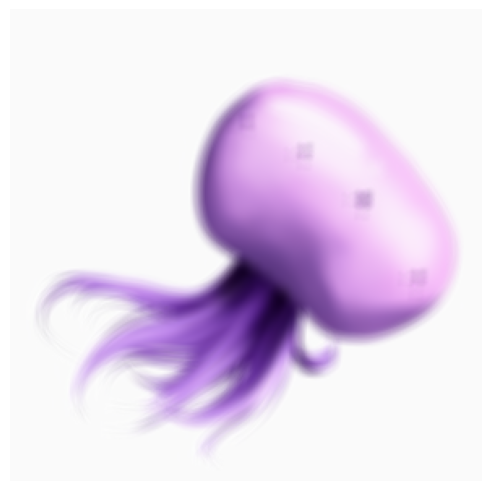

In [8]:
from torchzero.nn.functional.pad import pad
from torchzero.nn.functional.crop import crop_to_shape

def sliding_distance(
    in1: torch.Tensor,
    in2: torch.Tensor,
    stride: int | Sequence[int] = 1,
    mode: Literal['full', 'valid', 'same'] = "valid",
    padding: int | Sequence[int] = 0,
    padding_mode="constant",
    value=None,
) -> torch.Tensor:
    patches, nreducedims = _get_conv_patches(
        in1,
        in2,
        stride=stride,
        mode=mode,
        padding=padding,
        padding_mode=padding_mode,
        value=value,
    )
    if mode in ('valid', 'full'): return (patches - in2).abs().sum([-i for i in range(1, nreducedims + 1)])
    # same mode
    return crop_to_shape((patches - in2).abs().sum([-i for i in range(1, nreducedims + 1)]), shape = in1.size(), where='center')

out = sliding_distance(image, torch.randn(10,10))
print(out.shape)
qimshow(1 - out)

torch.Size([3, 291, 291])
torch.Size([3, 291, 291])


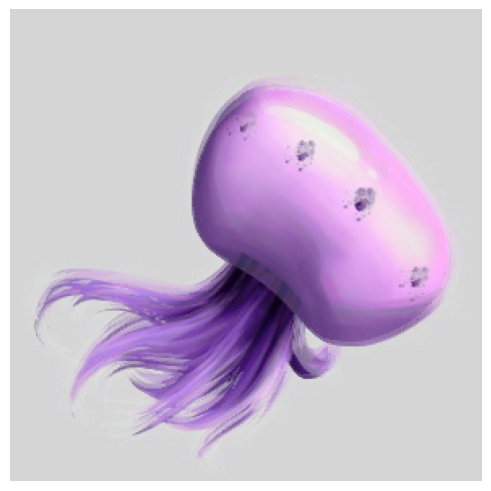

In [9]:
from torchzero.nn.functional.pad import pad
from torchzero.nn.functional.crop import crop_to_shape


def sliding_msort(
    in1: torch.Tensor,
    in2: torch.Tensor,
    rank,
    stride: int | Sequence[int] = 1,
    mode: Literal['full', 'valid', 'same'] = "valid",
    padding: int | Sequence[int] = 0,
    padding_mode="constant",
    value=None,
) -> torch.Tensor:
    patches, nreducedims = _get_conv_patches(
        in1,
        in2,
        stride=stride,
        mode=mode,
        padding=padding,
        padding_mode=padding_mode,
        value=value,
    )
    patches = (patches * in2).flatten(-nreducedims, -1).swapaxes(0, -1).msort()[rank].permute(2, 0, 1)
    print(patches.shape)
    if mode in ('valid', 'full'): return patches
    return crop_to_shape(patches.sum(-1), shape = in1.size(), where='center')

out = sliding_msort(image, torch.randn(10, 10), 1)
print(out.shape)
qimshow(out)

In [3]:
from torchzero.nn.functional.convolve import conv_layer
device = torch.device('cuda')
conv_layer(torch.randn(128, 12, 96, 96, device = device), torch.randn(32, 12, 3, 3, device=device), stride=(1, 2)).shape

torch.Size([128, 32, 94, 47])

In [11]:
import torch
model = torch.nn.TransformerEncoder(encoder_layer=torch.nn.TransformerEncoderLayer(100, 4, 200, batch_first=True), num_layers=3).to('cuda')
input = torch.randn(2, 10, 100).to('cuda')

def createHook(name):
    print(f"Hook for {name} is set")
    
    def hook(model, input, output):
        print(f"Hook working")

    return hook

for i in range(len(model.layers)):
    model.layers[i].self_attn.register_forward_hook(createHook(f"t_layer_{i}"))


model.eval()
with torch.no_grad():
    pred = model(input) 
    pred = pred.cpu().detach().numpy()

Hook for t_layer_0 is set
Hook for t_layer_1 is set
Hook for t_layer_2 is set
Hook working
Hook working
Hook working


d:\miniconda\envs\pytorch312\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
